# Read example thermometer data files from Jason Smith

Files are
```
./data/raw/20220905/
603_05Sep22.log
604_05Sep22.log
605_05Sep22.log
```

Parses data lines as regular expressions, and date stamps as DateTimes.

Jupyter IJulia notebook written in Julia; run in Julia 1.8.1.

In [1]:
using Dates

using PyPlot
ENV[ "MPLBACKEND" ] = "qt5agg"

using Interpolations
#using MAT
#using NetCDF

In [2]:
"Read and parse lines from Jason Smith's .log data file with time stamps."
function get_data(
        filename, 
        nheaderlines=7, nfooterlines=11,
        data_ex = Regex( "^\\[([0-9]{2}:[0-9]{2}:[0-9.]{6})\\]"
                *" ([0-9]{1,}),"
                *" ([0-9.]{1,})\$"),
        df=DateFormat("HH:MM:SS.sss")
    )
    
    nlines = countlines( filename ) # count input lines in file
    ndata = nlines - nheaderlines - nfooterlines # ideal max data length
    
    # initialize arrays
    dtime = Array{DateTime, 1}( undef, ndata )
    msec = Array{Int64, 1}( undef, ndata )
    temp = Array{Float32, 1}( undef, ndata )
    
    i = 0 #number of lines skipped or read
    idata = 0 #number of data lines read
    
    open( filename, "r" ) do a
        while i < nheaderlines
            i += 1
            readline(a)
        end
        while idata < ndata
            i += 1
            l = readline(a)
            # parse 1 line
            m = match( data_ex, l )
            if !isnothing(m)
                idata += 1
                dtime[idata] = DateTime( m[:1], df )
                msec[idata] = parse( Int64, m[:2] )
                temp[idata] = parse( Float32, m[:3] )
            end
        end
    end
    
    return dtime, msec, temp
end

dt2min(dt) = (dt-dt[1])./Minute(1.) # convert time to number in minutes


dt2min (generic function with 1 method)

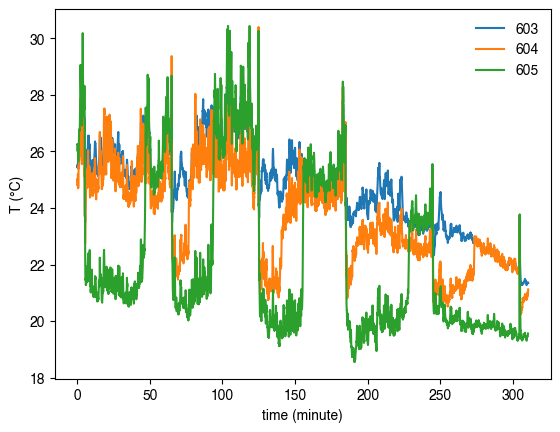

PyObject <matplotlib.legend.Legend object at 0x7fc6a62e56a0>

In [3]:
pathnames = "../data/raw/20220905"
filenames = joinpath.(pathnames, ["603_05Sep22.log", "604_05Sep22.log", "605_05Sep22.log"])

dtime603, msec, t603 = get_data( filenames[1] )
plot( dt2min(dtime603), t603 )

dtime604, msec, t604 = get_data( filenames[2] )
plot( dt2min(dtime604), t604 )

dtime605, msec, t605 = get_data( filenames[3] )
plot( dt2min(dtime605), t605 )

ylabel("T (°C)")
xlabel("time (minute)")
legend(["603", "604", "605"]; frameon=false)

Jason needs to confirm:
```
603 fat temp probe,
604 skinny probe with no stainless mesh
605 skinny probe with stainless mesh
```


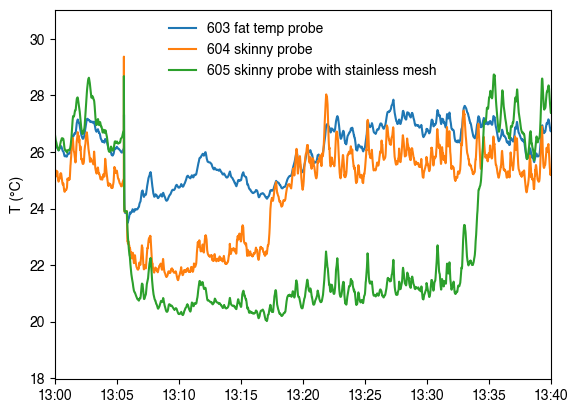

PyObject <matplotlib.legend.Legend object at 0x7f8822c2f820>

In [6]:
ax = subplot(1,1,1)
# for probe = 1:3
#     dtime, msec, temp = get_data( filenames[probe] )
#     plot( dtime, temp )
# end
plot( dtime603, t603 )
plot( dtime604, t604 )
plot( dtime605, t605 )
ylabel("T (°C)")
# xlim([DateTime(1,1,1,13,0,0), DateTime(1,1,1,17,0,0)])

xlim([DateTime(1,1,1,13,0,0), DateTime(1,1,1,13,40,0)])
X = ax.xaxis
mdates = PyPlot.matplotlib.dates
#X.set_major_locator(mdates.MinuteLocator(45))
X.set_major_formatter(mdates.DateFormatter("%H:%M")) # Specify the format - %b gives us Jan, Feb...
legend(["603 fat temp probe", "604 skinny probe", "605 skinny probe with stainless mesh"]; frameon=false)

Little cooling observed of 603.

Mesh on 605 keeps it wet and cool ~30 min, about ~2x as long as 604.

Skinny bare 604 is cooler than other 2 probes when dry. Perhaps it's subject to less radiative warming.

# Psychrometry

In [4]:
# constants
Cp = 1005

Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T,p=1e5,forceC=false)
    
P = p*1e-2 # P in hPa
if ( !forceC && T>200.0 )
    @info "Temperature $T in Kelvin detected."
    T = T - 273.15
end
esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
end

"""
qs(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qs [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function qs(p,T)
esat = es(T,p)
qsat = RdoRv*esat / (p + (RdoRv-1)*esat)  
end

"""
dqsdT = d(qs(p, Temp))/d(Temp) = qs(p,Temp)*Lv(Temp)/(Rv*Temp**2)  [K^{-1}]
using Wexler and Clausius-Clapeyron formulas
p[Pa], T[degrees C]
  
273, 273.15 shifts in Temp are deliberate, to offset other
inconsistencies in the thermo functions. SPdeS 01.July.2005
"""
dqsdT(p,Temp) = qs(p,Temp)*Lv(Temp+273)/(Rv*(Temp+273.15)^2)

"""
Tw=Twet(Tdry[C], qv[kg/kg], p[Pa])
Computes the wet bulb temperature from an isobaric process
by using heat internal energy -Cp*dT=L*dq to evaporate
and raise qv to qs(Twb).
Simon de Szoeke 2016-04-07
"""
function Twet(Tdry,qv,p,niter=5)

# initialize Tw, qw
Tw = Tdry # problem for temperatures greater than 100 C!
qs0 = qs(p,Tw)
qw = min(qs0, qv)

Lvap = 2.501e6 + (Cpv-Cw) * Tw
stepfac = nanmean(Cp/(Lvap*dqsdT(p, Tw))) # ~0.3

# Steps by 1/4 of saturation deficit and enforces -Cp*dT=L*dq by successive approximations
for iter = 1 : niter
    dq = stepfac * (qs(p,Tw) - qw)
    if dq<0; break; end
    Lvap = 2.501e6 + (Cpv-Cw) * Tw
    dT=-Lvap/Cp*dq
    qw=qw+dq
    Tw=Tw+dT
end
        
return Tw      
end

"""
    q = q_psychro(T[C], Tw[C], p[Pa])
    returns specific humidity from dry-bulb T and wet-bulb Tw.
    Simon de Szoeke 2020-01-31
"""
function q_psychro(T, Tw, p=101300.0, salfac=1.0)
# cd /Volumes/GoogleDrive/'My Drive'/Proposals/NSF_Oce2020/experiments/

# integrate without approximating Lv
# qw = 0.98*qs(p, Tw); # saturation specific humidity over the wet bulb
qw = salfac*qs(p, Tw); # saturation specific humidity over the wet bulb
dq = -Cp/(Cpv-Cw) * log( (L0 + (Cpv-Cw)*Tw) / (L0 + (Cpv-Cw)*T) );
q = qw - dq;
    
# # compute Lv(Tw)
# Lv = L0 + (Cpv-Cw) * Tw
# q = qw + Cp/Lv * (Tw - T)

# %q-q0 = about -1e-8 kg/kg, insignificant. Approximation is sufficient
return q
end

q_psychro

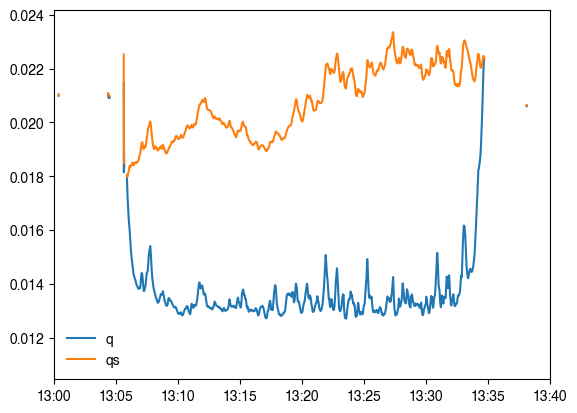

PyObject <matplotlib.legend.Legend object at 0x7fc6a8b81c40>

In [6]:
uniqueidx(v) = unique(i -> v[i], eachindex(v))
knots = Dates.value.(dtime603)
ui = uniqueidx(knots)

itp = LinearInterpolation(knots[ui], t603[ui])
t603_605 = itp( Dates.value.(dtime605) )
# itp = interpolate( (Dates.value.(dtime603),), t603, BSpline(Linear()) )

q = q_psychro.(t603_605, t605, 101300.0)
qw = qs.(101300.0, t603_605)

nanmask(f, x) = f(x) ? x : NaN
# how do I broadcast it? broadcast, map?
m2n(x) = nanmask(!ismissing, x) # dot-broadcasts
    
ii = t605.<t603_605
mask = zeros(size(ii))
mask[.!ii] .= NaN
plot(dtime605, mask.+q )
plot(dtime605, mask.+qw)
# tw = Twet(t603_605, q, 101300.0)

xlim([DateTime(1,1,1,13,0,0), DateTime(1,1,1,13,40,0)])
X = gca().xaxis
mdates = PyPlot.matplotlib.dates
#X.set_major_locator(mdates.MinuteLocator(45))
X.set_major_formatter(mdates.DateFormatter("%H:%M")) # Specify the format - %b gives us Jan, Feb...
legend(["q", "qs"]; frameon=false)

In [72]:
uniqueidx(v) = unique(i -> v[i], eachindex(v))
uniqueidx(knots)

37276-element Vector{Int64}:
     1
     2
     3
     4
     5
     6
     7
     8
     9
    10
    11
    12
    13
     ⋮
 37266
 37267
 37268
 37269
 37270
 37271
 37272
 37273
 37274
 37275
 37276
 37277